# Variational Autoencoding financial data

The idea is to create an encoding of financial data from a correlated pair of securities. The encoded data is the daily percentage changes of each security over a period of N days. 

After training the VAE, I test whether the encodings are relatively closer to each other over time. In other words, is tomorrow's encoding close to today's? For now I have completely ignored problems of lookahead bias and data crossover. 

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

from datetime import datetime
import pandas as pd

In [2]:
import requests
import os
import json
from dotenv import load_dotenv
load_dotenv(".keys")

True

In [20]:
def transform(data):
	d = np.array([(x[0], x[1]) for x in data]).T
	dates = d[0][::-1]
	prices = d[1][::-1]
	datadict = {
			"dates": dates.tolist(),
			"prices": prices.tolist()
		}
	return datadict, d.T

def api_request(symbol_text, url=None, **kwargs):
	key = os.environ.get('QUANDL_KEY')
	key = ''.join(['api_key=', key])
	#TODO change url and get datasettype part separate
	if url is None:
		url = os.environ.get('QUANDL_URL')
	url = url+symbol_text+'.json'
	url = url + '?'
	if len(kwargs)>0:
		counter = 0
		for k,v in kwargs.items():
			url = url + k + '=' + v
			url=url+'&'
			counter+=1
	url = ''.join([url,key])
	print(url)
	r = requests.get(url).json()
	d = r['dataset']['data']
	return d

def get_single_df(symbolname, startdate):
    dict_, d = transform(
        api_request(symbolname ,
                    start_date = startdate, 
                    )
    )
    df = pd.DataFrame(d[:,1], index = d[:,0])
    df.columns = [symbolname]
    return df

def get_multi_df(symbol_list, startdate):
    df = pd.DataFrame()
    for symbol in symbol_list:
        ddf = get_single_df(symbol, startdate).astype(float)
        df = df.join(ddf , how='outer')
    return df

In [301]:
df = get_multi_df(['gs', 'c'],'2017-01-01' )

#projected return of buying today
df = (df.shift(1)-df)/df

https://www.quandl.com/api/v3/datasets/WIKI/gs.json?start_date=2017-01-01&api_key=o7ncuZZnSjU8JNYUBnxq
https://www.quandl.com/api/v3/datasets/WIKI/c.json?start_date=2017-01-01&api_key=o7ncuZZnSjU8JNYUBnxq


In [302]:
data = np.array(df[1:])

In [303]:
normalized_data = (data - data.mean(axis=0)) / data.std(axis=0)

In [25]:
normalized_data.std(axis=0)

array([ 1.,  1.])

In [26]:
class PriceData:
    def __init__(self, array):
        self.array = array
        self.datalength = array.shape[0]
        
        self.pointer = 0
    def next_batch(self, n):
        if self.pointer + n + 1 >= self.datalength:
            self.pointer = np.random.randint(n)
        next_batch = self.array[self.pointer : min(self.pointer+n, self.datalength)]
        self.pointer += n
        return next_batch
        

In [325]:
def datalookback(data, lb):
    a_s = []
    for i in range(lb):
        if i==lb-1:
            a_s.append(data[i:])
        else:
            a_s.append(data[i:-lb+1+i])
    print(a_s[1].shape)
    return np.concatenate(a_s, axis=1)

In [335]:
# with lookback
pricedata = PriceData(datalookback(normalized_data, 10))

# no lookback
#pricedata = PriceData(normalized_data)

(299, 2)


In [281]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)
# def xavier_init(fan_in, fan_out, constant=1): 
#     """ Xavier initialization of network weights"""
#     # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
#     low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
#     high = constant*np.sqrt(6.0/(fan_in + fan_out))
#     return tf.random_uniform((fan_in, fan_out), 
#                              minval=low, maxval=high, 
#                              dtype=tf.float32)

In [282]:
# fully-conected layer
def dense(x, inputFeatures, outputFeatures, scope=None, with_w=False):
    matrix = tf.Variable(xavier_init([inputFeatures, outputFeatures]))
    bias = tf.Variable( tf.zeros(shape = [outputFeatures]))
    if with_w:
        return tf.matmul(x, matrix) + bias, matrix, bias
    else:
        return tf.matmul(x, matrix) + bias

In [336]:
n_z = 3         # size of code 
batchsize = 32
data_dim = 20
h_size = 30

# ENCODER
X = tf.placeholder(tf.float32, shape=[None, data_dim])
def encoder(x):
    with tf.variable_scope("encoder"):
        E_1 = tf.nn.relu(dense(x, data_dim, h_size))
        E_2 = tf.nn.relu(dense(E_1, h_size, h_size))
        z_mean = dense(E_2, h_size, n_z)
        z_stddev = dense(E_2, h_size, n_z)
    return z_mean, z_stddev

# DECODER
def decoder(z):
    with tf.variable_scope("decoder"):
        D_1 = tf.nn.relu(dense(z, n_z, h_size))
        D_log_prob = dense(D_1, h_size, data_dim)
        #D_prob = tf.nn.sigmoid(D_log_prob)
    return D_log_prob#D_prob



z_mean, z_stddev = encoder(X)


samples = tf.random_normal([tf.shape(X)[0], n_z], 0, 1, dtype=tf.float32)
z_code = z_mean + (z_stddev * samples)

generated_images = decoder(z_code)


# LOSS
generation_loss = tf.reduce_mean(tf.square(X - generated_images), axis = 1) #MSE
# generation_loss = -tf.reduce_sum(X * tf.log(1e-8 + generated_images) 
#                                  + 
#                                  (1-X) * tf.log(1e-7 + 1 - generated_images)
#                                  ,1)
latent_loss = 0.5 * tf.reduce_sum(tf.square(z_mean) + tf.square(z_stddev) - tf.log(tf.square(z_stddev)) - 1,1)
loss = tf.reduce_mean(generation_loss + latent_loss)

optimizer = tf.train.AdamOptimizer(0.0001).minimize(loss)

In [337]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [338]:
mb_size = batchsize
for it in range(90000):
    X_mb = pricedata.next_batch(mb_size)

    _, gen_loss, lat_loss = sess.run((optimizer, generation_loss, latent_loss), 
                                     feed_dict={X: X_mb})
    if it % 10000 == 0:
        print('Iter: {}'.format(it))
        print('gen_loss: {:.4}'. format(np.mean(gen_loss)))
        print('lat_loss: {:.4}'.format(np.mean(lat_loss)))
        print()

Iter: 0
gen_loss: 36.2
lat_loss: 8.418

Iter: 10000
gen_loss: 0.9867
lat_loss: 0.6002

Iter: 20000
gen_loss: 0.884
lat_loss: 0.07587

Iter: 30000
gen_loss: 1.1
lat_loss: 0.02671

Iter: 40000
gen_loss: 0.7035
lat_loss: 0.003906

Iter: 50000
gen_loss: 0.9511
lat_loss: 0.01065

Iter: 60000
gen_loss: 0.6731
lat_loss: 0.0007118

Iter: 70000
gen_loss: 0.7792
lat_loss: 0.0003815

Iter: 80000
gen_loss: 0.7634
lat_loss: 0.0002076



In [214]:
def vector_distance(df, nshift):
    return np.nanmean(np.sum((df-df.shift(nshift))[nshift:]**2, axis=1)**.5 )

In [341]:
means = sess.run(z_code, feed_dict={X: pricedata.array})
m = pd.DataFrame(means)
print(vector_distance(m, 1))
n = m.sample(m.shape[0])
print(vector_distance(n,4))

2.28304
2.24931


In [342]:
means = sess.run(z_mean, feed_dict={X: pricedata.array})
m = pd.DataFrame(means)
print(vector_distance(m,1))
n = m.sample(m.shape[0])
print(vector_distance(n,4))

0.00686328
0.00649942


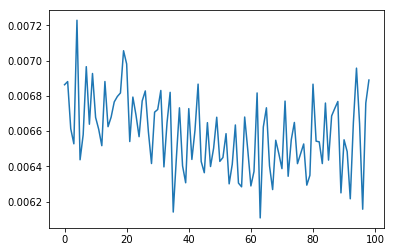

In [343]:
vds = []

means = sess.run(z_mean, feed_dict={X: pricedata.array})
m = pd.DataFrame(means)
for i in range(1,100):
    vd = vector_distance(m,i)
    vds.append(vd)
plt.plot(vds)

In [85]:
f = pd.DataFrame(np.random.normal(0,1,[9999,20]))
print(vector_distance(f))

6.251123111021005


In [37]:
np.random.normal(0,1,[308,20]).shape

(308, 20)

In [462]:
n = m.sample(m.shape[0])
np.mean(np.sum((n-n.shift(1))**2, axis=1)**.5)

1.6314297914505005

In [464]:
np.sum((n-n.shift(1))**2, axis=1)**.5

156    0.000000
111    0.992212
97     1.406284
143    1.472060
197    1.729580
142    1.727712
258    2.303002
75     0.412611
257    1.766589
49     2.017220
100    2.996723
201    2.161570
263    2.278406
24     0.035527
191    0.254428
86     1.929938
55     1.217537
160    1.730768
193    1.370728
261    1.614218
158    2.140208
64     2.137058
114    0.061556
116    3.170644
184    3.122384
251    0.339305
246    0.468829
293    3.739318
6      2.559864
262    0.672618
         ...   
15     3.849693
22     3.744702
39     1.626676
157    1.689088
289    0.270396
278    2.912472
281    0.084510
61     2.727432
130    1.555405
93     1.710295
235    1.756573
18     1.472773
155    0.137773
227    0.603282
74     0.942208
241    1.681362
83     1.522941
76     0.473064
73     2.976344
69     2.893823
276    0.197499
292    2.169687
70     1.663108
30     4.130243
126    1.777059
80     3.340203
214    4.433860
45     2.580897
199    2.105612
129    1.750712
Length: 308, dtype: floa